In [1]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

In [2]:
class SimpleBreastCancerDataset:
    def __init__(self, root_dir):
        """
        Inicializa el dataset
        root_dir: directorio que contiene las carpetas 'benign', 'malignant', 'normal'
        """
        self.root_dir = Path(root_dir)
        self.categories = ['benign', 'malignant', 'normal']
        self.data = []  # Aquí guardaremos la información de cada imagen y su máscara
        self.load_dataset()
        
    def load_dataset(self):
        """Carga todas las imágenes y sus máscaras correspondientes"""
        print("Cargando dataset...")
        
        for category in self.categories:
            category_path = self.root_dir / category
            if not category_path.exists():
                print(f"¡Advertencia! No se encuentra la carpeta: {category}")
                continue
                
            # Buscar todas las imágenes (excluyendo máscaras)
            images = [f for f in os.listdir(category_path) 
                     if f.endswith('.png') and '_mask' not in f]
            
            print(f"\nProcesando categoría: {category}")
            print(f"Imágenes encontradas: {len(images)}")
            
            for img_name in images:
                # Construir ruta de la imagen
                img_path = category_path / img_name
                
                # Intentar diferentes patrones de nombre para la máscara
                mask_patterns = [
                    img_name.replace('.png', '_mask.png'),
                    img_name.replace('.png', '_mask_1.png'),
                    img_name.replace(' .png', '_mask.png')
                ]
                
                mask_found = False
                for mask_pattern in mask_patterns:
                    mask_path = category_path / mask_pattern
                    if mask_path.exists():
                        self.data.append({
                            'category': category,
                            'image_path': str(img_path),
                            'mask_path': str(mask_path)
                        })
                        mask_found = True
                        break
                
                if not mask_found:
                    print(f"No se encontró máscara para: {img_name}")
    
    def get_statistics(self):
        """Obtiene estadísticas básicas del dataset"""
        stats = {}
        for category in self.categories:
            category_data = [item for item in self.data 
                           if item['category'] == category]
            stats[category] = len(category_data)
            
        return stats
    
    def visualize_sample(self, index):
        """Visualiza una imagen y su máscara"""
        sample = self.data[index]
        image = Image.open(sample['image_path'])
        mask = Image.open(sample['mask_path'])
        
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.title(f"Imagen - {sample['category']}")
        plt.axis('off')
        
        plt.subplot(1, 2, 2)
        plt.imshow(mask, cmap='gray')
        plt.title('Máscara')
        plt.axis('off')
        plt.show()

def verify_dataset(dataset_path):
    """
    Verifica y muestra información básica del dataset
    """
    print(f"Verificando dataset en: {dataset_path}")
    dataset = SimpleBreastCancerDataset(dataset_path)
    
    print("\nEstadísticas del dataset:")
    stats = dataset.get_statistics()
    
    total_images = sum(stats.values())
    print(f"\nTotal de imágenes: {total_images}")
    
    for category, count in stats.items():
        percentage = (count / total_images) * 100
        print(f"{category}: {count} imágenes ({percentage:.1f}%)")
    
    # Visualizar una muestra de cada categoría
    print("\nMostrando una muestra de cada categoría...")
    for i, sample in enumerate(dataset.data):
        if sample['category'] != dataset.data[i-1]['category'] if i > 0 else True:
            dataset.visualize_sample(i)
    
    return dataset

Verificando dataset en: K:\Maestria\Percepción Computacional\tarea\t3\evaluacion-de-segmentacion\dataset
Cargando dataset...

Procesando categoría: benign
Imágenes encontradas: 437

Procesando categoría: malignant
Imágenes encontradas: 210

Procesando categoría: normal
Imágenes encontradas: 133

Estadísticas del dataset:

Total de imágenes: 780
benign: 437 imágenes (56.0%)
malignant: 210 imágenes (26.9%)
normal: 133 imágenes (17.1%)

Mostrando una muestra de cada categoría...


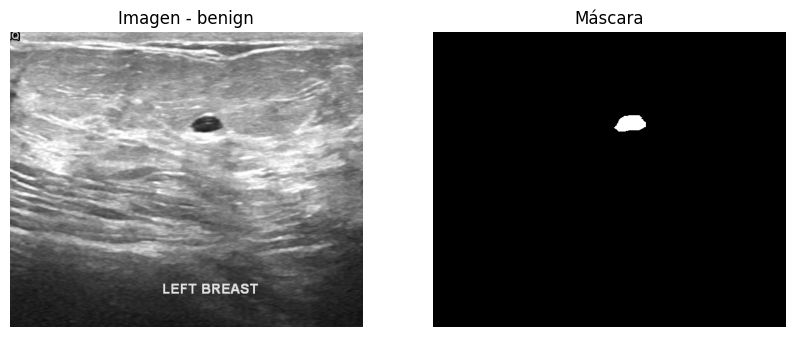

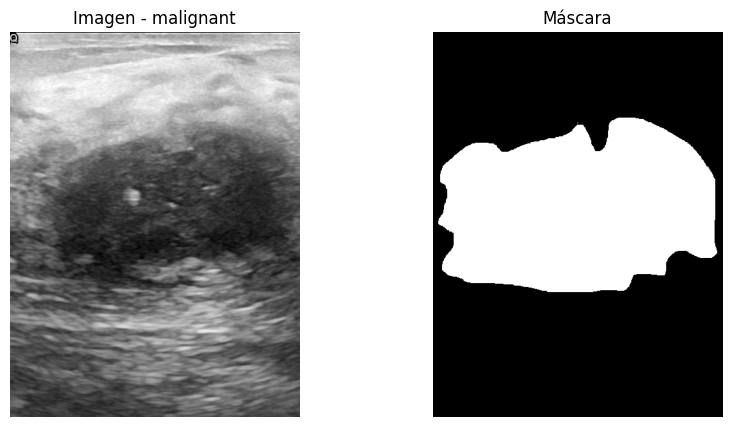

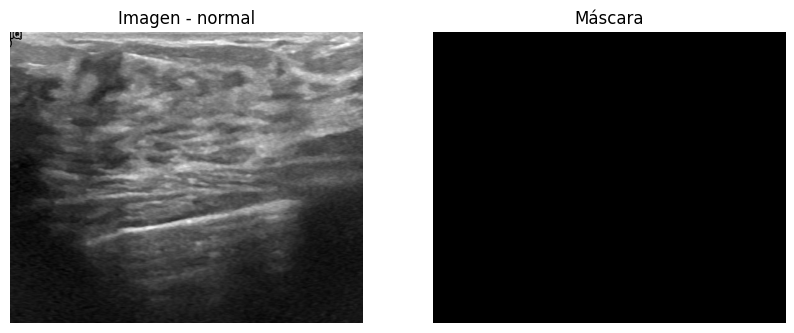

In [3]:
# Ejecutar con tu ruta
dataset_path = r"K:\Maestria\Percepción Computacional\tarea\t3\evaluacion-de-segmentacion\dataset"
dataset = verify_dataset(dataset_path)

In [4]:
def analyze_image_dimensions(dataset):
    """Analiza las dimensiones de todas las imágenes y máscaras"""
    image_sizes = {}
    mask_sizes = {}
    
    print("Analizando dimensiones de imágenes y máscaras...")
    for item in dataset.data:
        # Analizar imagen
        with Image.open(item['image_path']) as img:
            img_size = img.size
            image_sizes[img_size] = image_sizes.get(img_size, 0) + 1
            
        # Analizar máscara
        with Image.open(item['mask_path']) as mask:
            mask_size = mask.size
            mask_sizes[mask_size] = mask_sizes.get(mask_size, 0) + 1
    
    # Visualizar resultados
    plt.figure(figsize=(15, 5))
    
    # Gráfico de tamaños de imágenes
    plt.subplot(1, 2, 1)
    plt.bar([f'{s[0]}x{s[1]}' for s in image_sizes.keys()], 
            list(image_sizes.values()))
    plt.title('Distribución de Tamaños de Imágenes')
    plt.xticks(rotation=45)
    
    # Gráfico de tamaños de máscaras
    plt.subplot(1, 2, 2)
    plt.bar([f'{s[0]}x{s[1]}' for s in mask_sizes.keys()], 
            list(mask_sizes.values()))
    plt.title('Distribución de Tamaños de Máscaras')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    return image_sizes, mask_sizes

def analyze_mask_coverage(dataset):
    """Analiza el porcentaje de área cubierta por las máscaras"""
    coverage_by_category = {cat: [] for cat in dataset.categories}
    
    print("Analizando cobertura de máscaras...")
    for item in dataset.data:
        with Image.open(item['mask_path']) as mask:
            mask_array = np.array(mask.convert('L'))
            total_pixels = mask_array.size
            white_pixels = np.sum(mask_array > 0)
            coverage = (white_pixels / total_pixels) * 100
            coverage_by_category[item['category']].append(coverage)
    
    # Crear box plot
    plt.figure(figsize=(10, 6))
    plt.boxplot([coverage_by_category[cat] for cat in dataset.categories],
                labels=dataset.categories)
    plt.title('Distribución de Cobertura de Máscaras por Categoría')
    plt.ylabel('Porcentaje de Área Cubierta (%)')
    plt.show()
    
    return coverage_by_category

def show_random_samples(dataset, samples_per_category=3):
    """Muestra múltiples muestras aleatorias de cada categoría"""
    plt.figure(figsize=(15, 5*len(dataset.categories)))
    
    for i, category in enumerate(dataset.categories):
        # Obtener índices de imágenes de esta categoría
        category_samples = [idx for idx, item in enumerate(dataset.data) 
                          if item['category'] == category]
        
        # Seleccionar muestras aleatorias
        selected_samples = np.random.choice(category_samples, 
                                          min(samples_per_category, len(category_samples)), 
                                          replace=False)
        
        for j, sample_idx in enumerate(selected_samples):
            # Cargar imagen y máscara
            with Image.open(dataset.data[sample_idx]['image_path']) as img, \
                 Image.open(dataset.data[sample_idx]['mask_path']) as mask:
                
                # Calcular posición en el subplot
                plt.subplot(len(dataset.categories), samples_per_category*2, 
                          i*samples_per_category*2 + j*2 + 1)
                plt.imshow(img)
                plt.title(f'{category} - Imagen {j+1}')
                plt.axis('off')
                
                plt.subplot(len(dataset.categories), samples_per_category*2, 
                          i*samples_per_category*2 + j*2 + 2)
                plt.imshow(mask, cmap='gray')
                plt.title(f'{category} - Máscara {j+1}')
                plt.axis('off')
    
    plt.tight_layout()
    plt.show()




Análisis de dimensiones:
Analizando dimensiones de imágenes y máscaras...


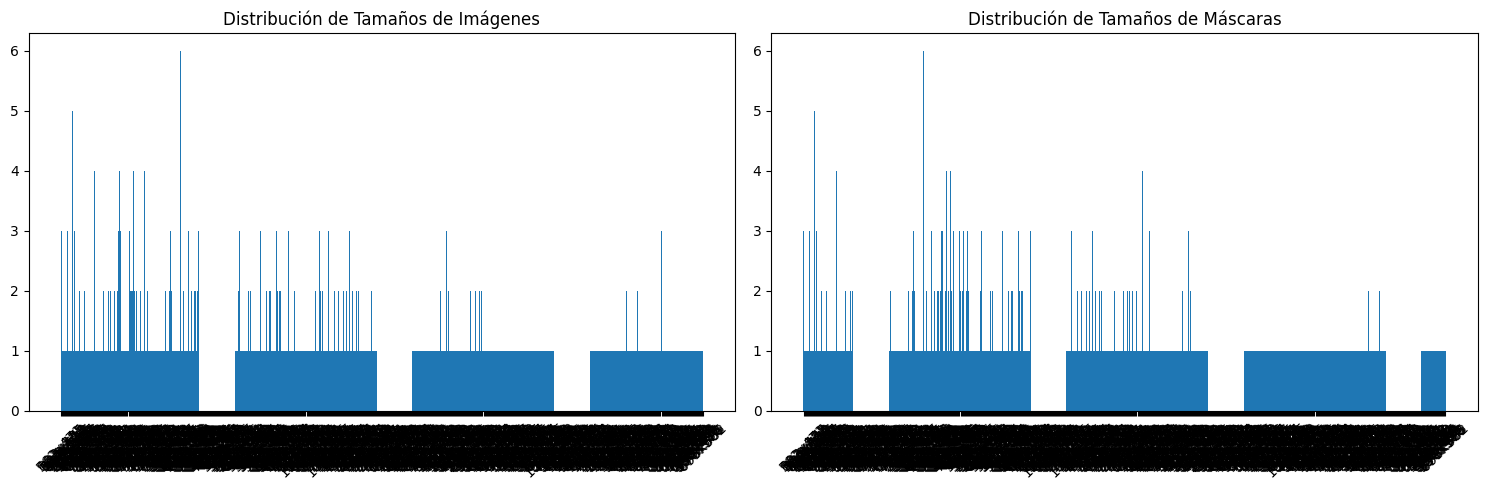


Análisis de cobertura de máscaras:
Analizando cobertura de máscaras...


C:\Users\Luciano Grandi\AppData\Local\Temp\ipykernel_33928\2569951021.py:55: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([coverage_by_category[cat] for cat in dataset.categories],


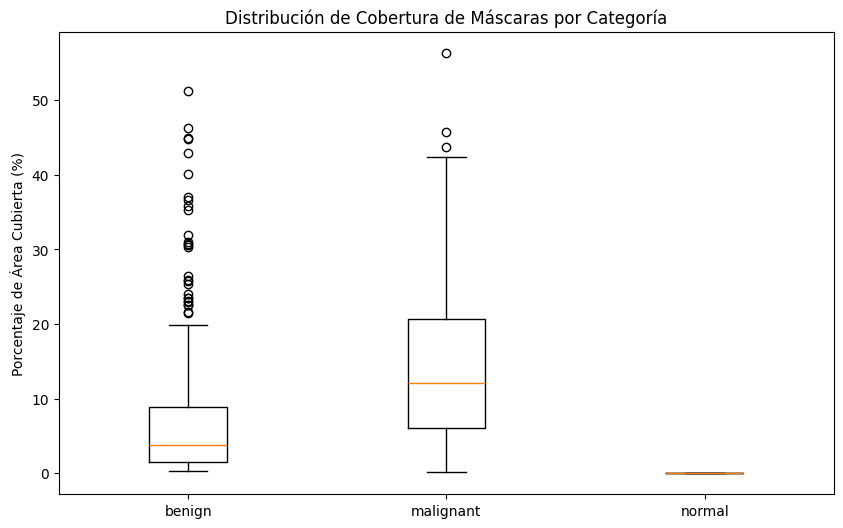


Mostrando muestras aleatorias por categoría:


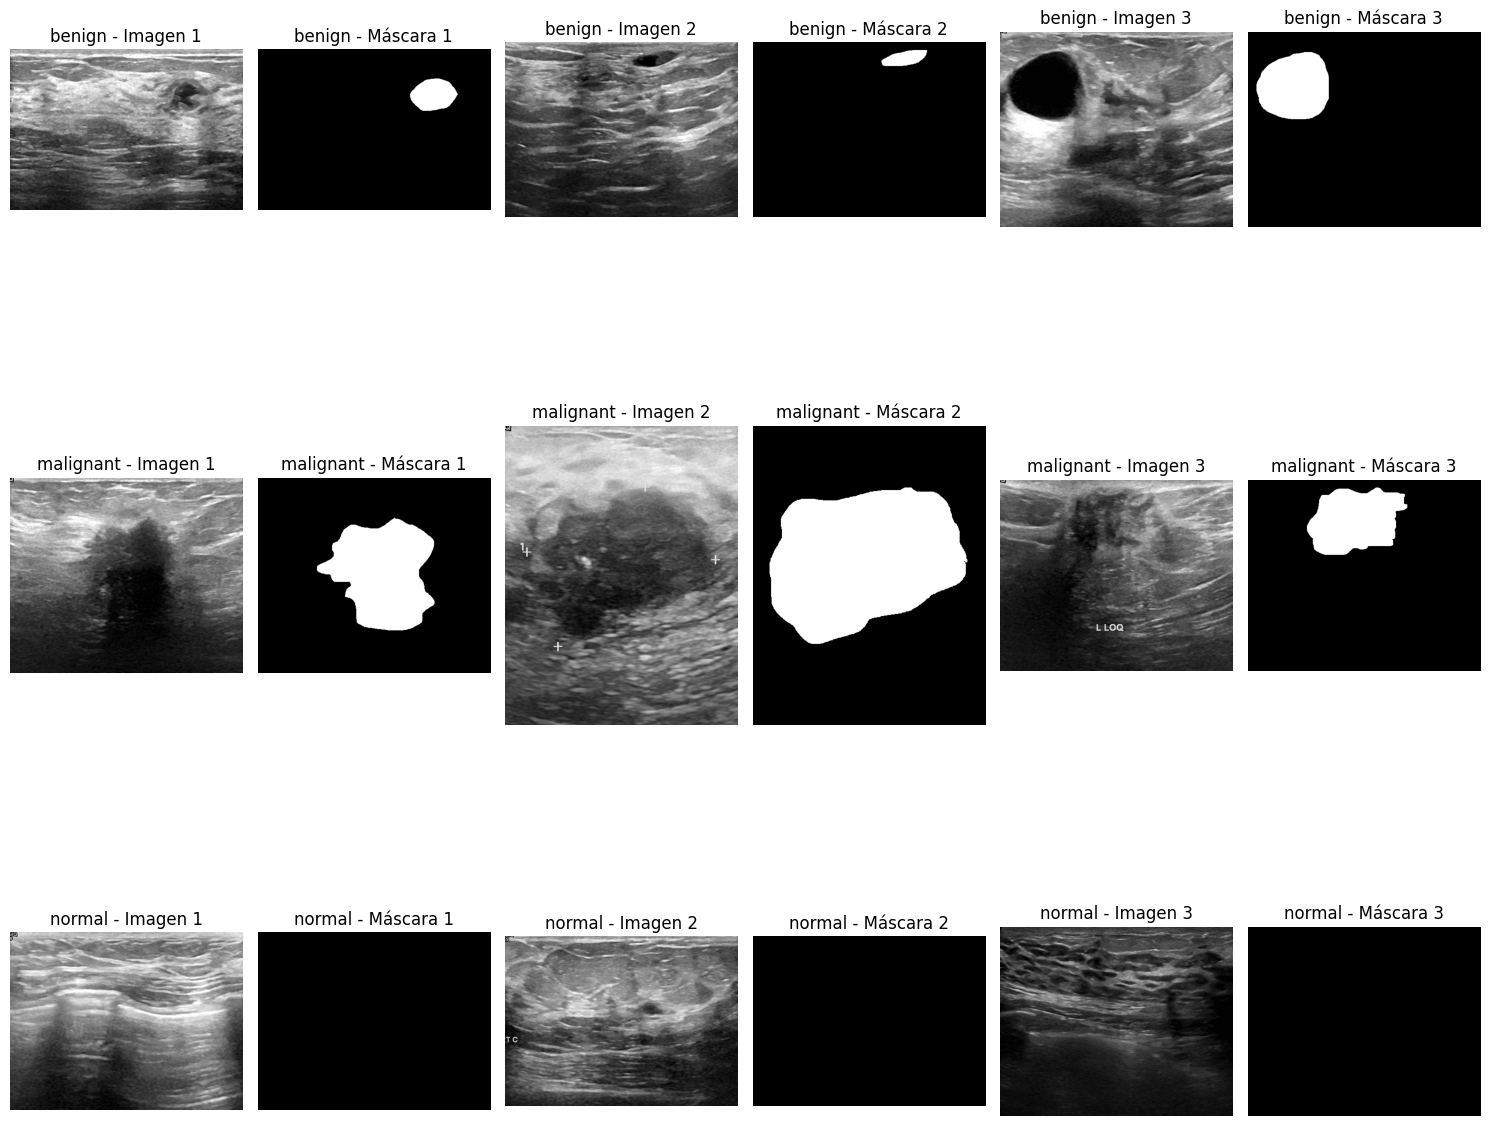

In [5]:
# Ejecutar los análisis
print("\nAnálisis de dimensiones:")
image_sizes, mask_sizes = analyze_image_dimensions(dataset)

print("\nAnálisis de cobertura de máscaras:")
coverage_stats = analyze_mask_coverage(dataset)

print("\nMostrando muestras aleatorias por categoría:")
show_random_samples(dataset, samples_per_category=3)

Distribución del Dataset:


Total: 780 imágenes
Benigno (Benign): 437 imágenes (56.0%)
Maligno (Malignant): 210 imágenes (26.9%)
Normal: 133 imágenes (17.1%)
El dataset está desbalanceado, con una mayoría de casos benignos.


Análisis de Cobertura de Máscaras (Imagen 1):


Casos benignos: típicamente cubren entre 0-10% del área, con algunos valores atípicos hasta 50%
Casos malignos: mayor cobertura, típicamente entre 5-20%, con algunos casos llegando al 45%
Casos normales: prácticamente sin cobertura (cercano a 0%), lo cual es esperado ya que son tejidos sanos


Distribución de Tamaños (Imagen 2):


Las imágenes y máscaras parecen tener tamaños variados
Los gráficos de distribución muestran múltiples tamaños diferentes
Necesitaremos normalizar estos tamaños antes del entrenamiento


Características de las Imágenes (Imagen 3):


Las imágenes son ecografías en escala de grises
Los casos benignos muestran lesiones más pequeñas y definidas
Los casos malignos muestran áreas más grandes e irregulares
Los casos normales no muestran áreas marcadas en las máscaras

In [6]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

class PreprocessedBreastDataset(Dataset):
    def __init__(self, root_dir, img_size=(256, 256), transform=None):
        self.root_dir = Path(root_dir)
        self.img_size = img_size
        self.transform = transform
        self.data = []
        self.load_dataset()

    def load_dataset(self):
        categories = ['benign', 'malignant', 'normal']
        for category in categories:
            category_path = self.root_dir / category
            if not category_path.exists():
                print(f"¡Advertencia! No se encuentra la carpeta: {category}")
                continue
                
            images = [f for f in os.listdir(category_path) 
                     if f.endswith('.png') and '_mask' not in f]
            
            print(f"Encontradas {len(images)} imágenes en categoría {category}")
            
            for img_name in images:
                img_path = category_path / img_name
                mask_path = category_path / img_name.replace('.png', '_mask.png')
                if mask_path.exists():
                    self.data.append({
                        'image': str(img_path),
                        'mask': str(mask_path),
                        'category': category
                    })

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        
        # Cargar imagen y máscara
        image = np.array(Image.open(sample['image']).convert('L'))
        mask = np.array(Image.open(sample['mask']).convert('L'))
        
        # Redimensionar
        image = Image.fromarray(image).resize(self.img_size)
        mask = Image.fromarray(mask).resize(self.img_size)
        
        # Convertir a numpy arrays
        image = np.array(image)
        mask = np.array(mask)

        # Normalizar
        image = image.astype(np.float32) / 255.0
        mask = mask.astype(np.float32) / 255.0

        # Convertir a tensor
        image = torch.FloatTensor(image).unsqueeze(0)
        mask = torch.FloatTensor(mask).unsqueeze(0)

        return image, mask, sample['category']

def verify_preprocessing(dataset_path):
    """Verifica que el preprocesamiento funcione correctamente"""
    print("Creando dataset...")
    dataset = PreprocessedBreastDataset(dataset_path)
    print(f"Dataset creado con {len(dataset)} imágenes")
    
    # Mostrar algunas muestras procesadas
    fig, axes = plt.subplots(3, 2, figsize=(10, 15))
    
    # Procesar 3 muestras diferentes
    for i in range(3):
        print(f"Procesando muestra {i+1}...")
        
        # Obtener muestra
        image, mask, category = dataset[i]
        
        # Visualizar
        axes[i, 0].imshow(image.squeeze(), cmap='gray')
        axes[i, 0].set_title(f'{category}\nImagen')
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(mask.squeeze(), cmap='gray')
        axes[i, 1].set_title(f'{category}\nMáscara')
        axes[i, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

Encontradas 437 imágenes en categoría benign
Encontradas 210 imágenes en categoría malignant
Encontradas 133 imágenes en categoría normal
Dataset creado con 780 imágenes

Visualizando diferentes muestras del dataset...
Creando dataset...
Encontradas 437 imágenes en categoría benign
Encontradas 210 imágenes en categoría malignant
Encontradas 133 imágenes en categoría normal
Dataset creado con 780 imágenes
Procesando muestra 1...
Procesando muestra 2...
Procesando muestra 3...


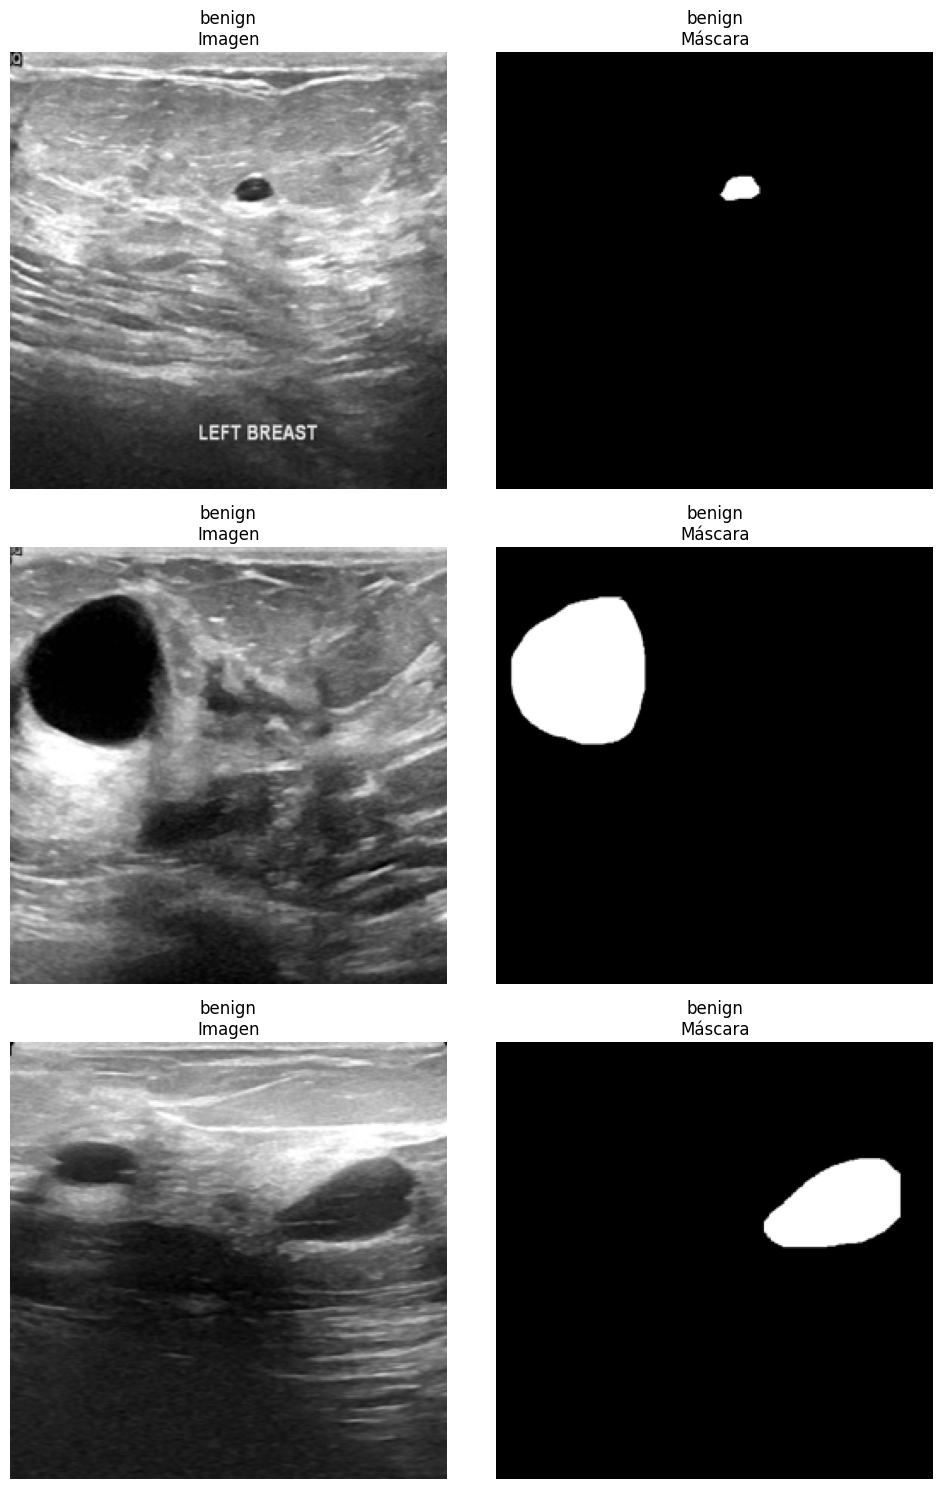

In [7]:
# Ejecutar visualizaciones
dataset_path = r"K:\Maestria\Percepción Computacional\tarea\t3\evaluacion-de-segmentacion\dataset"

dataset = PreprocessedBreastDataset(dataset_path)
print(f"Dataset creado con {len(dataset)} imágenes")


# Visualizar diferentes muestras
print("\nVisualizando diferentes muestras del dataset...")
verify_preprocessing(dataset_path)